In [1]:
pacman::p_load(tidyverse, readxl, vcfR, VariantAnnotation, rtracklayer, Biostrings, Rsamtools, plyranges)


data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")

cov_info = read_tsv("../../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")

## filter outlier
data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))

library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

listMarts(host="https://grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

# transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
#                                   "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
#       filters ="ensembl_gene_id",
#       values  =gene_names$ensembl_gene_id,
#       mart    =mart)


transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"

## Get all the TF sites
library(plyranges)
tf_files = system("ls ../../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 111
ENSEMBL_MART_SNP,Ensembl Variation 111
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 111


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”


[1] 138

In [2]:
library(plyranges)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)
total_length = sum(seqlengths(BSgenome.Hsapiens.UCSC.hg19)[1:24])
total_length

Loading required package: BSgenome



[1] 3095677412

In [4]:
# Find Recurrent variants
pacman::p_load(gt, gtExtras)
pacman::p_load(webshot2,htmltools)

rec_muts = data %>% filter(Mutation %in% c("T/G","A/C")) %>% mutate(mut = glue::glue("{CHROM}:{POS} {Mutation}")) %>%
    dplyr::count(mut) %>% dplyr::arrange(-n) %>% filter(n > 1) %>% pull(mut)

gnomad = vroom::vroom(file = "gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz") %>% dplyr::rename(c(seqnames = chromosome),
                               start = start_position, end=end_position) %>%
            mutate(seqnames = glue::glue("chr{seqnames}")) %>%
            as_granges()

tab1 = data %>% mutate(mut = glue::glue("{CHROM}:{POS} {Mutation}"), CHROM=glue::glue("chr{CHROM}"),start=POS, end=POS) %>%
    filter(mut %in% rec_muts) %>% mutate(Mutation = factor(Mutation, levels=c("T/G","A/C","G/A"))) %>%
    arrange(Mutation,mut) %>% mutate(`Amplicon-Seq Validated` = c("Yes","Yes","Yes","Yes","Yes","Not enough DNA")) %>%
    dplyr::rename(c(seqnames=CHROM)) %>%
    dplyr::select(c(seqnames, start,end, Mutation, `Individual ID`, Dx, `Amplicon-Seq Validated`)) %>% 
    as_granges() %>% join_nearest(gnomad) %>% data.frame() %>%
    dplyr::select(c( seqnames, start, Mutation, `Individual.ID`, Dx,, `Amplicon.Seq.Validated`)) %>%
    dplyr::rename(c( chromosome= seqnames, position=start,diagnosis=Dx, 
                    `Subject ID`=Individual.ID))

gts <- function(gt_table){
   gt:::as.tags.gt_tbl(gt_table)
}

tab2 = tab1 %>% gt(groupname_col = c("chromosome","position","Mutation")) %>% 
    tab_header(
    title = md('**Recurrent Variants**'),
    subtitle = 'Same Variants Same Site (SVSS)')%>%
    tab_style(style=list(cell_fill("gray"),cell_text(color="black",weight="bold")),
             locations = cells_row_groups()) %>%
#     cols_label(`upper bound of observed to expected loss-of-function variants (LOEUF)` = "LOEUF") %>%
    cols_label("Amplicon.Seq.Validated" = html("Amplicon-Seq<br>Validated"))%>%
#     tab_footnote(footnote= ("upper bound of observed to expected loss-of-function variants (LOEUF)"),
#                 locations = cells_column_labels("upper bound of observed to expected loss-of-function variants (LOEUF)")) %>%
    cols_align(align = "center") %>%
    tab_options(table.font.size=px(12),column_labels.font.size = px(16), heading.title.font.weight = "bold", heading.title.font.size = px(18),
                column_labels.font.weight = "bold")


tab2 %>% gts() 

# Sys.setenv(
#   CHROMOTE_CHROME = "/usr/lib64/chromium-browser/"
# )

pacman::p_load(chromote)
chrm <- Chrome$new(
path = find_chrome(),
args = "--disable-gpu --headless"
)
chrm$get_path()

gtsave(tab2,filename = "../../figures/recurrent_table.pdf")
                

Rows: 19704 Columns: 77
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): gene, transcript, constraint_flag, transcript_type, gene_id, gene_...
dbl (69): obs_mis, exp_mis, oe_mis, mu_mis, possible_mis, obs_mis_pphen, exp...
lgl  (1): brain_expression

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Shiny tags cannot be represented in plain text (need html)

`google-chrome` and `chromium-browser` were not found. Try setting the `CHROMOTE_CHROME` environment variable to the executable of a Chromium-based browser, such as Google Chrome, Chromium or Brave or adding one of these executables to your PATH.



ERROR: Error in initialize(...): Invalid path to Chrome


In [5]:
## adapted from https://github.com/Rashesh7/PanBody_manuscript_analyses/blob/main/Signature_Enrichment/Testes_analyses_Signature_and_Enrichment_analyses.Rmd

library(MutationalPatterns)

## Get target vcfs
scz_vcf = granges(v_scz)
ctrl_vcf  = granges(v_ctrl)
genome(ctrl_vcf) = "hg19"
genome(scz_vcf) = "hg19"

get_triRate <- function(target_vcf, ref_genome = "BSgenome.Hsapiens.UCSC.hg19", surveyed=NULL){
    ## Compute 96 trinuc context and total muts per sample
    muts0 = mut_matrix(target_vcf, ref_genome)

     muts <- as_tibble(muts0) %>% 
          mutate(mutType = rownames(muts0)) %>% 
          rowwise() %>%
          mutate(totMuts = sum(c_across(where(is.numeric)))) %>% 
          mutate(context = paste0(str_sub(mutType,1,1),str_sub(mutType,3,3),str_sub(mutType,7,7))) %>% 
          group_by(context) %>% 
          dplyr::summarise(count = sum(totMuts), .groups = "drop")

    ## Get mean sites per tissue
    if(is.null(surveyed)){
        sequences  = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
    } else{
        sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
    }

    ## count trinuc freq
    tri_freqs <- trinucleotideFrequency(sequences)

    #Convert to pyr reference
    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop")
        colnames(tri_freqs_summary) <- c("context", paste0("opps_", "WGS"))
        muts <- muts %>% 
        left_join(tri_freqs_summary, by = "context")

    ## Generate triRateDF
    triRateDF <- tibble()
    freqDF <- muts %>% 
          rowwise() %>%
          mutate(meanOpps = mean(c_across(cols = starts_with("opps_")))) %>% 
          mutate(rate = count/meanOpps) %>% 
#           mutate(rate = rate/sum(lengths(target_vcf))) %>% 
          dplyr::select(context, rate)
    triRateDF <- triRateDF %>% bind_rows(freqDF)
    return(triRateDF)
}

Loading required package: NMF

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following object is masked from ‘package:S4Vectors’:

    nrun




In [6]:

oe_func2 <- function(target_vcf,region,regionName, triRateTable, b,
                    surveyed=NULL,ref_genome = "BSgenome.Hsapiens.UCSC.hg19",cpg=FALSE){

    
    ## calculate observed and expected ratio
    n_muts = length(target_vcf)
    
    if(is.null(surveyed)){
        library(ref_genome, character.only = TRUE)
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c(b[1],b[3])))
    } else{
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c(b[1],b[3])))
    }

    if(is.null(surveyed)){
        surveyed_region = region
    } else{
        surveyed_region = surveyed %>% join_overlap_intersect(region)
    }
    
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    surveyed_region_length = sum(letterFrequency(reg_seqs, letters=c(b[1],b[3])))
    
    ## To remove CpG sites, this code can be commented out if we are focusing on CpG sites. 
    if(b[1]=="C"){
        surveyed_length = surveyed_length - sum(dinucleotideFrequency(gwide.seq)[,c("CG")])
        surveyed_region_length = surveyed_region_length - sum(dinucleotideFrequency(reg_seqs)[,c("CG")])
    }
    

    # Find which mutations lie in the surveyed genomic region
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(target_vcf),
    start(target_vcf) - extension,
    end(target_vcf) + extension
    ))

    target_vcf$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    
    target_vcf = target_vcf %>% filter(!(dn %in% plus_cg | dn %in% neg_cg))
    
    target_vcf = target_vcf[ (target_vcf$REF == b[1] & as.character(unlist(target_vcf$ALT)) == b[2]) | 
                  (target_vcf$REF == b[3] & as.character(unlist(target_vcf$ALT)) == b[4])]
    
    triRateTable = get_triRate(target_vcf = target_vcf)
    
    muts_in_region = target_vcf %>% filter_by_overlaps(surveyed_region)
    observed = sum(countOverlaps(surveyed_region, target_vcf))

    #Add base to start and end to get correct trinuc counts
    surveyed_region@ranges@start <- as.integer(surveyed_region@ranges@start - 1)
    surveyed_region@ranges@width <- as.integer(surveyed_region@ranges@width + 2)
    
    #Count trinuc freq
    sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    tri_freqs <- trinucleotideFrequency(sequences)

    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";	
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        #Convert to pyr reference
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop") %>% 
        left_join((triRateTable), by = "context") %>% 
        mutate(expected = count * (rate))
    
    if(cpg){
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) == "CG")
    } else{
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) != "CG") %>%
            filter(substr(context,2,2) == b[1])
    }

    expected = sum(tri_freqs_summary$expected)
    
    ## calculate CIs
#     n_sims = 10000
#     observations = replicate(n_sims, 
#                              sum(countOverlaps(target_vcf[sort(sample(length(target_vcf), size=length(target_vcf), 
#                                                                       replace=TRUE))],surveyed_region)))
#     cis <- quantile(observations, probs = c(0.025, 0.975))
    
    tmp = poisson.test(c(observed,surveyed_region_length),c(expected, surveyed_region_length))
#     pval = sum(observations/expected <1)/n_sims
    pval = tmp$p.value
    cis = tmp$conf.int
    
    res = data.frame(n_muts,
                surveyed_length,
                regionName,
                surveyed_region_length,
                expected,
                observed,
                     oe = observed/expected,
                    low_ci= cis[1],
                    high_ci = cis[2], pval = pval)
    return(res)

}


In [7]:
scz_tritable = get_triRate(target_vcf = scz_vcf)



In [8]:
distance_tf = c("5000","2000","1000","500","100")


base_list = list(c("T","G","A","C"),
                c("C","A","G","T"),
                c("C","G","G","C"),
                c("C","T","G","A"),
                c("T","A","A","T"),
                c("T","C","A","G"))

df = as.data.frame(transcript.gr)
tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                              end=df$transcription_start_site),strand=df$STRAND)

tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
dhs$ntile = ntile(dhs$score,20)
dhs = dhs[dhs$ntile==20]

library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        region = GenomicRanges::resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
        region = region %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) # %>% reduce_ranges()
#         region = resize(tfbs_dhs_promoter, width=2*as.numeric(x), fix="center")
        res= oe_func2(scz_vcf, region=region, regionName="TFBS+DHS+promoter",
                      triRateTable = scz_tritable,b = b,cpg = FALSE)
        res$base_change = paste0(b[1],">",b[2])
        return(res)
    })
    
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% mutate(dists = dist_from_tss)
    
    return(stats_df)
}

base_df = lapply(base_list, function(x){get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T","T>A","T>C","T>G"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100)))

options(repr.plot.width=8, repr.plot.height=4)
p1=full_stat %>% ggplot(aes(x=dists, y=oe)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Binned distance to TFBS + DHS + promoter\nat non-CpG sites",color="Base Change", y="observed/expected") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c(
  "#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat




library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        region = GenomicRanges::resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
        region = region %>% filter_by_overlaps(dhs) # %>% reduce_ranges()
#         region = resize(tfbs_dhs, width=2*as.numeric(x), fix="center")
        res= oe_func2(scz_vcf, region=region, regionName="TFBS+DHS",
                      triRateTable = scz_tritable,b = b,cpg = FALSE)
        res$base_change = paste0(b[1],">",b[2])
        return(res)
    })
    
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% mutate(dists = dist_from_tss)
    
    return(stats_df)
}

base_df = lapply(base_list, function(x){get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T","T>A","T>C","T>G"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100)))

options(repr.plot.width=8, repr.plot.height=4)
p2=full_stat %>% ggplot(aes(x=dists, y=oe)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Binned distance to TFBS + DHS\nat non-CpG sites",color="Base Change", y="observed/expected") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c(
  "#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval,base_change,dists
<int>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2236,1690956123,TFBS+DHS+promoter,125291912,17.68746956,31,1.7526532,1.190842760,2.487751,3.887936e-03,T>G,5000
2236,1690956123,TFBS+DHS+promoter,20890342,2.89412902,10,3.4552710,1.656936489,6.354368,8.452889e-04,T>G,2000
2236,1690956123,TFBS+DHS+promoter,5817393,0.76873681,6,7.8050120,2.864300649,16.988235,1.490106e-04,T>G,1000
2236,1690956123,TFBS+DHS+promoter,1807943,0.21830928,5,22.9032867,7.436625841,53.448730,3.446531e-06,T>G,500
2236,1690956123,TFBS+DHS+promoter,211948,0.02421152,2,82.6053032,10.003820365,298.402436,2.884146e-04,T>G,100
2236,1142153999,TFBS+DHS+promoter,104377399,20.45674034,14,0.6843710,0.374151985,1.148258,1.829869e-01,C>A,5000
2236,1142153999,TFBS+DHS+promoter,18747001,3.55693824,2,0.5622813,0.068094874,2.031154,5.957919e-01,C>A,2000
2236,1142153999,TFBS+DHS+promoter,6091463,1.09746916,2,1.8223747,0.220697977,6.583047,3.000440e-01,C>A,1000
2236,1142153999,TFBS+DHS+promoter,2390133,0.40336755,0,0.0000000,0.000000000,9.145213,1.000000e+00,C>A,500


n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval,base_change,dists
<int>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2236,1690956123,TFBS+DHS,228009078,32.54741142,53,1.6283937,1.21977859,2.1299791,0.0008198831,T>G,5000
2236,1690956123,TFBS+DHS,44248130,6.25562287,16,2.5576989,1.46194581,4.1535433,0.0007854169,T>G,2000
2236,1690956123,TFBS+DHS,13591958,1.88183042,8,4.2511801,1.83535745,8.3765219,0.0007464222,T>G,1000
2236,1690956123,TFBS+DHS,4627796,0.61541032,5,8.1246606,2.63805392,18.9602612,0.0004421892,T>G,500
2236,1690956123,TFBS+DHS,692460,0.08739763,3,34.3258747,7.07880332,100.3151901,0.0001042189,T>G,100
2236,1142153999,TFBS+DHS,179118393,35.85722556,23,0.6414328,0.40661335,0.9624641,0.0295294659,C>A,5000
2236,1142153999,TFBS+DHS,36236963,7.13165571,4,0.5608796,0.15282080,1.4360746,0.3444179698,C>A,2000
2236,1142153999,TFBS+DHS,12074505,2.31083536,2,0.8654879,0.10481459,3.1264405,1.0000000000,C>A,1000
2236,1142153999,TFBS+DHS,4739566,0.86928458,2,2.3007425,0.27863051,8.3110777,0.2162999255,C>A,500


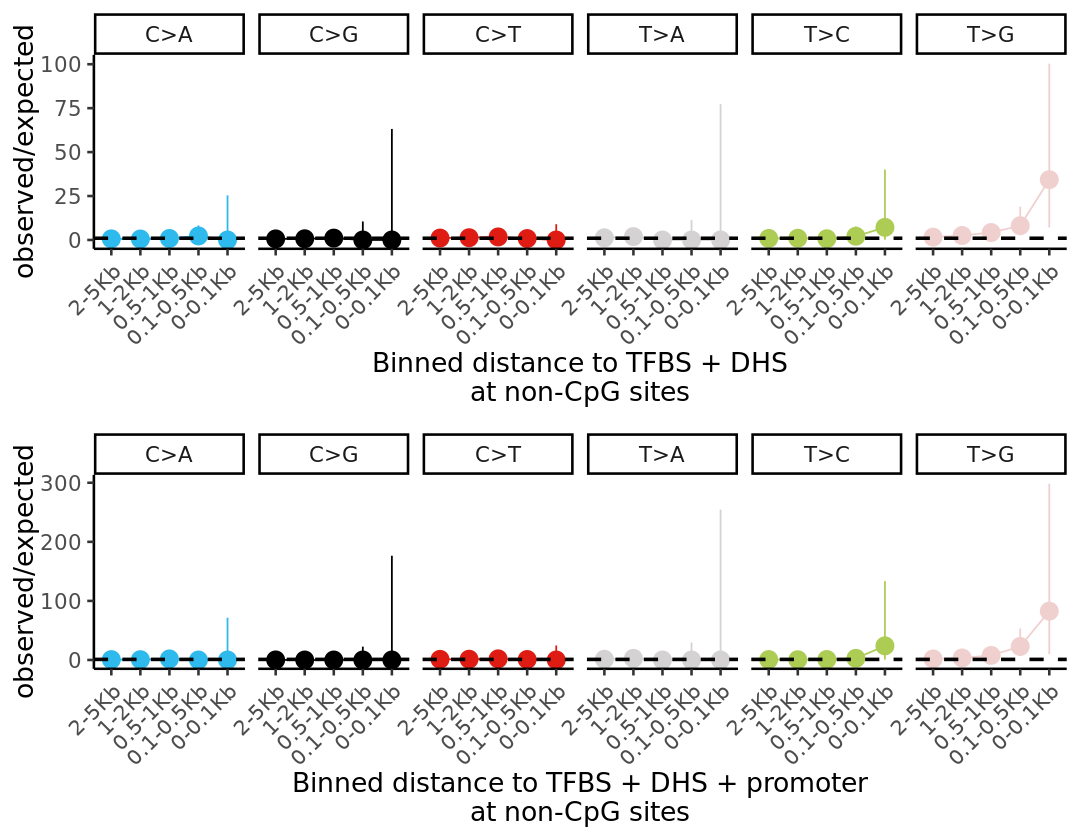

In [9]:
options(repr.plot.width=9, repr.plot.height=7)
p3 = ggpubr::ggarrange(p2,p1, ncol=1, nrow=2)
p3

ggsave(p3, filename = "../../figures/tg_tfbs_dhs_promoter_no_outlier.pdf",device="pdf",width=9,height=7)


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  cancer_type = col_character(),
  mutation = col_character(),
  id = col_character(),
  obs_exp = col_double()
)



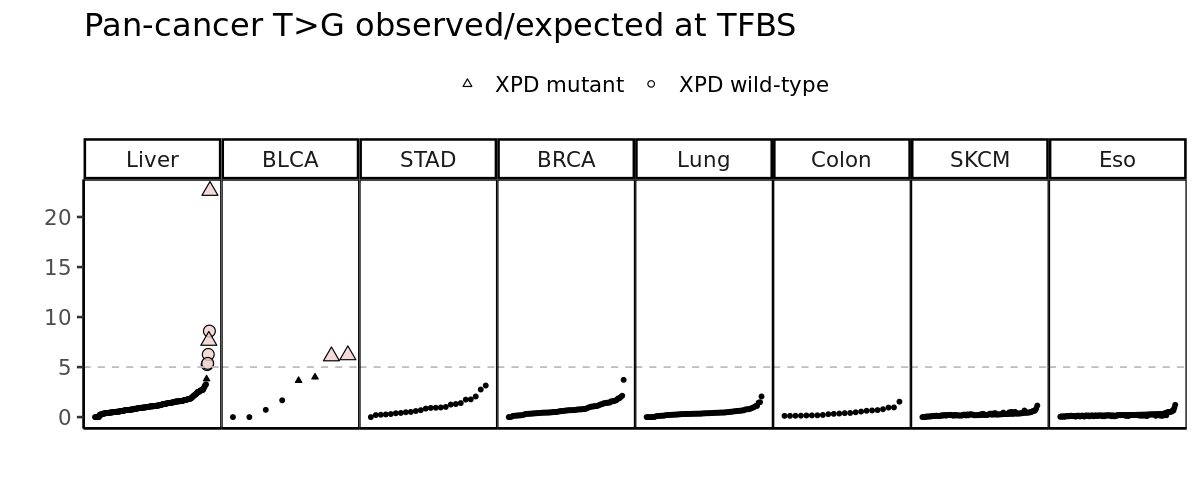

In [10]:
## Plotting the enrichment of T>G mutations across cancer types

# data = read_table("../../data/liver_vova//rate_figure_v2 _new")
data = read_table("http://genetics.bwh.harvard.edu/downloads/Vova/SCZ/rate_figure_v3")
data = data %>% filter(mutation !="a>l")


data$cancer_type = factor(data$cancer_type, levels=c("Liver","BLCA","STAD","BRCA","Lung","Colon","SKCM","Eso"))

mut_cols = c("#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")

xpd_samples = c("DO720","DO639","DO483","DO45293_SP99313","DO45267_SP99257","DO44097","DO22839")

options(repr.plot.width=10, repr.plot.height=4)

tg_data = data %>% filter(mutation =="T>G")

p1= tg_data %>% mutate(xpd_mutant = ifelse(id %in% xpd_samples, "XPD mutant","XPD wild-type")) %>%
    ggplot(aes(x=fct_reorder(id,obs_exp),y=obs_exp)) +
#     geom_violin(outlier.shape=NA, fill="#F0D0CE") +
    geom_point(aes(shape = xpd_mutant),fill = ifelse(tg_data$obs_exp >5, alpha("#F0D0CE",0.8), alpha("black",1)), color="black",
               size=ifelse(tg_data$obs_exp > 5, 3,1)) +
    scale_shape_manual(values=c(24,21)) +
    facet_grid(cols=vars(cancer_type),scales = "free_x") +
    theme_classic(16) +
#     scale_y_continuous(trans="log2") +
    theme(legend.position = "top", axis.text.x = element_blank(),
        panel.border = element_rect(colour = "black",fill = NA), panel.spacing = unit(0, "lines"),
        axis.ticks.x = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()) +
    geom_hline(yintercept = 5,linetype=2, color="gray") +
    scale_x_discrete(expand= c(0.1,0))+
    labs(x= "", y="", 
            color="Observed/Expected > 5", title="Pan-cancer T>G observed/expected at TFBS", shape="")
p1

ggsave(p1,filename = "../../figures/tg_rate_across_tumors.pdf",device = "pdf",height=4,width=10)

xpd_mutant,m
<chr>,<dbl>
XPD mutant,7.7157207
XPD wild-type,0.6999571



	Wilcoxon rank sum test with continuity correction

data:  tmp %>% filter(xpd_mutant == "XPD mutant") %>% pull(obs_exp) and tmp %>% filter(xpd_mutant == "XPD wild-type") %>% pull(obs_exp)
W = 4490, p-value = 6.27e-06
alternative hypothesis: true location shift is not equal to 0


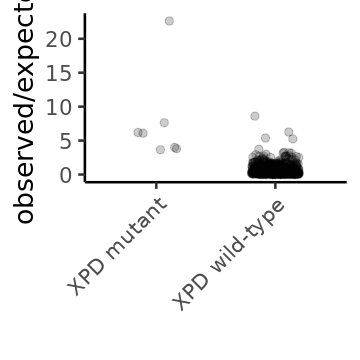

In [11]:
## Wilcox analysis of o/e in XPD mutants compared to non-XPD mutations

tmp = tg_data %>% mutate(xpd_mutant = ifelse(id %in% xpd_samples, "XPD mutant","XPD wild-type"))
tmp %>% group_by(xpd_mutant) %>% summarise(m = mean(obs_exp))

options(repr.plot.width=3, repr.plot.height=3)
p2 = tmp %>% ggplot(aes(x=xpd_mutant,y=obs_exp)) + 
    geom_jitter(width=0.2, height=0, alpha=0.2, size=2) +
    theme_classic(16) +
    theme(axis.text.x=element_text(angle = 45,hjust = 1,vjust = 1)) +
    labs(x="", y ="observed/expected")
p2

ggsave("../../figures/xpd_vs_nonxpd.pdf",device="pdf",height=3,width=3)

wilcox.test(tmp %>% filter(xpd_mutant == "XPD mutant") %>% pull(obs_exp),
           tmp %>% filter(xpd_mutant == "XPD wild-type") %>% pull(obs_exp))


Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Region Start, targetscan_Region End, targetscan_Item Na...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 86 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): ID, Dx
dbl (1): mean_cov

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

[1] 138

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 111
ENSEMBL_MART_SNP,Ensembl Variation 111
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 111


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”


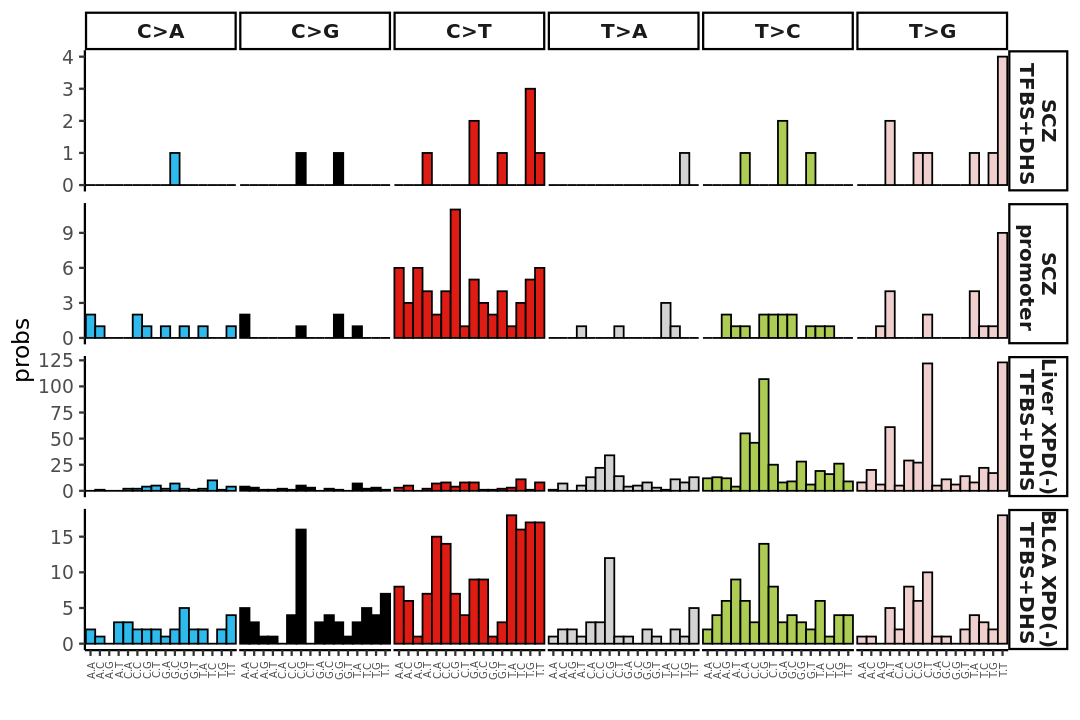

In [12]:
## Vova process
pacman::p_load(MutationalPatterns)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)

data = read_csv("../../data/annotated-calls.csv")
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")

## filter outlier
data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))



## Get all the TF sites
library(plyranges)
tf_files = system("ls ../../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

listMarts(host="https://grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

# transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
#                                   "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
#       filters ="ensembl_gene_id",
#       values  =gene_names$ensembl_gene_id,
#       mart    =mart)


transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"


signatures = get_known_signatures()
epimark = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")

epimark$ntile = ntile(epimark$score, 10)


epimark_top = epimark[epimark$ntile == 10]


v_scz_dhs = granges(v_scz) %>% filter_by_overlaps(epimark_top) %>% filter_by_overlaps(tf_final) 
genome(v_scz_dhs) = "hg19"

df = as.data.frame(transcript.gr)
# df$expr = median_pcw_tpm$value[match(df$ensembl_gene_id,median_pcw_tpm$gene)]
# df = df %>% mutate(ntile = ntile(expr,2)) %>% filter(ntile == 2)

tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),
                strand=df$STRAND)

tss.gr = flank(tss.gr, width=2500 + width(tss.gr),start=TRUE)
#tss.gr = c(flank(tss.gr,10000, start=TRUE), flank(tss.gr, 10000, start=FALSE))

h = findOverlaps(v_scz,tss.gr)
v_scz_tss = v_scz[queryHits(h)]
genome(v_scz_tss) = "hg19"


mut_mat_dhs = mut_matrix(v_scz_dhs, ref_genome=ref_genome)
mut_mat_tss = mut_matrix(granges(v_scz_tss), ref_genome=ref_genome)

# comp11 = comp11[match(rownames(mut_mat_dhs), comp11$base_change),]

tfbs_liver_mut = read.table("http://genetics.bwh.harvard.edu/downloads/Vova/SCZ/TFBShigh_Liver_mut")
liver_gr = data.frame(seqnames=paste0("chr",tfbs_liver_mut$V1), 
                                      REF = str_sub(tfbs_liver_mut$V4,2,2), ALT=tfbs_liver_mut$V5,
                      start=tfbs_liver_mut$V2, end=tfbs_liver_mut$V2) %>% as_granges()
genome(liver_gr) = "hg19"
seqlevelsStyle(liver_gr) = "UCSC"
mut_mat_liver = mut_matrix(liver_gr, ref_genome = ref_genome)

tfbs_bladder_mut = read.table("http://genetics.bwh.harvard.edu/downloads/Vova/SCZ/TFBShigh_BLCA_mut")
bladder_gr = data.frame(seqnames=paste0("chr",tfbs_bladder_mut$V1), 
                                      REF = str_sub(tfbs_bladder_mut$V4,2,2), ALT=tfbs_bladder_mut$V5,
                      start=tfbs_bladder_mut$V2, end=tfbs_bladder_mut$V2) %>% as_granges()
genome(bladder_gr) = "hg19"
seqlevelsStyle(bladder_gr) = "UCSC"
mut_mat_bladder= mut_matrix(bladder_gr, ref_genome = ref_genome)


mut_mat_scz = data.frame(tnc=rownames(mut_mat_dhs))

mut_mat_scz$`SCZ\n TFBS+DHS`=mut_mat_dhs[,1]
mut_mat_scz$`SCZ\n promoter` = mut_mat_tss[,1]


mut_mat_scz$`Liver XPD(-)\n TFBS+DHS` = mut_mat_liver[,1]
mut_mat_scz$`BLCA XPD(-)\n TFBS+DHS` = mut_mat_bladder[,1]


options(repr.plot.width=9, repr.plot.height=6)
p1 = mut_mat_scz %>% mutate(subs =rep(c("C>A","C>G","C>T","T>A","T>C","T>G"),each=16)) %>%
    pivot_longer(cols= c(-tnc,-subs), names_to="sigs", values_to ="probs") %>% 
    mutate(sigs = factor(sigs,levels=c("SCZ\n TFBS+DHS","SCZ\n promoter","Liver XPD(-)\n TFBS+DHS","BLCA XPD(-)\n TFBS+DHS"))) %>%
                        ggplot(aes(x=tnc, y=probs)) + 
                        geom_bar(aes(fill=subs),color="black",stat="identity",width = 1, show.legend = FALSE) + 
                            facet_grid(sigs~subs, scales="free")+ 
                            theme_classic(14) + 
                            labs(x="") +
                            scale_fill_manual(values = c("#2EBAED", "#000000", "#DE1C14","#D4D2D2", "#ADCC54", "#F0D0CE")) +
                            theme(strip.text = element_text(size= 12, face="bold"), 
                                  axis.text.x = element_text(angle=90,vjust=0.5, size=6),
                                 panel.spacing.x = unit(0.1, "lines"),
                                 panel.grid = element_blank()) +
                            scale_x_discrete(labels= paste(substr(mut_mat_scz$tnc, 1, 1), substr(mut_mat_scz$tnc, 7, 7), sep = "."))
p1

ggsave(p1, filename = "../../figures/xpd_trinuc_context_no_outlier.pdf",device="pdf",width=9, height=8)

Rows: 20 Columns: 9
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): distance, dataset
dbl (7): obs.exp, observed, expected, sites_exp, sites_obs, CI_low, CI_high

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


distance,obs.exp,observed,expected,sites_exp,sites_obs,dataset,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
0-0,106.000000,53,10,20,1,TFBS_high,54.608687,205.746168
1-11,15.272727,84,10,20,11,TFBS_high,8.017889,29.092348
12-22,10.727273,59,10,20,11,TFBS_high,5.554015,20.719358
23-33,5.272727,29,10,20,11,TFBS_high,2.607693,10.661448
34-44,2.545455,14,10,20,11,TFBS_high,1.154421,5.612614
45-55,1.272727,7,10,20,11,TFBS_high,0.501265,3.231460


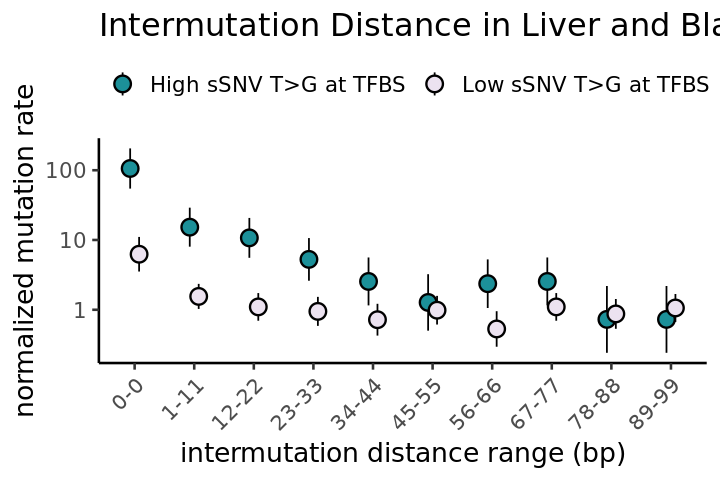

In [13]:
## Plotting recurrence rate at TFBS 

rec = vroom::vroom("../../data/cancer_plotting_vova//observed_expected_TFBS_distance_CI.tsv")

head(rec)

options(repr.plot.width=6, repr.plot.height=4)
p1 = rec %>% ggplot(aes(x=distance, y=obs.exp)) +
    geom_pointrange(aes(ymin=CI_low,ymax=CI_high, fill=dataset),size=1,pch=21, position=position_dodge2(width = 0.3)) +
    theme_classic(16) +
    labs(x="intermutation distance range (bp)",y="normalized mutation rate",fill="", 
         title="Intermutation Distance in Liver and Bladder cancer samples") +
    scale_fill_manual(values = c("#1c9099","#ece2f0"),labels=c("High sSNV T>G at TFBS","Low sSNV T>G at TFBS"))+
    scale_y_log10() +
    theme(axis.text.x = element_text(angle=45,hjust=1,vjust=1),
         legend.position="top")

p1

ggsave(filename = "../../figures/interdistance_plots_cancer.pdf",p1,device="pdf",height=4,width=6)